# Hauptkomponentenanalyse #

Dieses Notebook zeigt die Durchführung der Hauptkomponentenanalyse unter Verwendung einer numerischen Minimierungsfunktion als Blackbox. Vektoren und Matrizen werden aus der Bibliothek numpy verwendet. Insbesondere benötigt man folgende numpy-Befehle:

np.asarray(L) verwandelt eine in Listenstruktur dargestellte Matrix in eine numpy-Matrix

np.dot(u,v) Skalarprodukt zweier Vektoren

np.outer(u,v) Matrix der Produkte u_i*v_j zweier Vektoren 

M@v Multiplikation einer Matrix mit einem Vektor

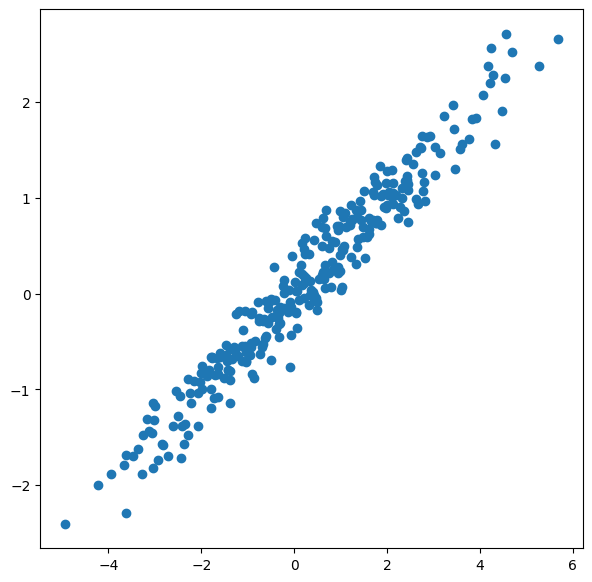

In [1]:
# 2d- Zufallsdaten erzeugen
import numpy as np
rng = np.random.default_rng() # Ein Zufallszahlengenerator 
# 2D Daten: fast auf einer schrägen Linie + etwas Rauschen
t = rng.normal(size=300)
X = np.column_stack([2*t + 0.2*rng.normal(size=300), 1*t + 0.2*rng.normal(size=300)])
# ... und visualisieren
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7)); plt.scatter(X[:, 0], X[:, 1]); plt.show()

Daten zentrieren und in eine numpy-Matrix verwandeln

In [2]:
def zentriert(X):
    X = np.asarray(X, dtype=float)
    return X-X.mean(axis=0)
print(zentriert([[5,1],[6,3],[8,6]]))
print(np.mean(zentriert([[5,1],[6,3],[8,6]]),axis=0)) # Nahezu [0,0]

[[-1.33333333 -2.33333333]
 [-0.33333333 -0.33333333]
 [ 1.66666667  2.66666667]]
[ 2.96059473e-16 -1.48029737e-16]


In [3]:
from scipy.optimize import minimize
def pca1d(X):
    X = zentriert(X)
    n, d = X.shape 
    # Zielfunktion: Summe quadrierter Rekonstruktionsfehler
    def MSE(u): # mean square error
        fehler=0
        for i in range(n):
            diff=X[i,]-u*np.dot(u,X[i,])
            fehler+=np.dot(diff,diff)
        return fehler/n
    # Nebenbedingung: ||u||^2 = 1  als Funktion, deren Werte 0 sein müssen
    cons = {'type': 'eq', 'fun': lambda u: np.dot(u, u) - 1.0}
    x0=[0]*d; x0[0]=1 # Startvektor für die Suche
    res = minimize(MSE, x0, method="SLSQP", constraints=[cons])
    u = res.x # Hauptkomponentenvektor, Einträge sind Ladungen
    scores = X @ u # Komponentenwerte
    X_recon =  np.outer(scores, u)
    rmse=np.sqrt(MSE(u))
    return u, X_recon, res, rmse

u, X_recon, res, rmse = pca1d(X)
print("u =", u,"RMSE=",rmse)
print("success:", res.success, "| iters:", res.nit, "| fun:", res.fun)

u = [0.89410317 0.44786122] RMSE= 0.20422561858582583
success: True | iters: 7 | fun: 0.041708103286763214


Zum Vergleich: PCA mit einem Profi-Tool

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
transformiert = pca.fit_transform(X)
print(pca.components_)

[[0.89410203 0.44786332]]


PCA mehrdimensional

In [5]:
def pca_k(X, k=2):
    X = np.asarray(X, dtype=float)
    n, d = X.shape
    R = X # Das sind jeweils die Daten, aus denen eine weitere Komponente extrahiert wird
    U = np.zeros((k, d)) # Hier werden die Basisvektoren gespeichert
    scores = np.zeros((n, k)) # Speichert x_i.u_j
    rng = np.random.default_rng()
    for j in range(k):
        u, X1, res, rmse = pca1d(R)
        U[j] = u # Neuer Basisvektor gefunden
        scores[:, j] =R @ u 
        R = R - np.outer(R @ u, u) # entferne Anteil entlang u
    X_recon = scores @ U # Linearkombination
    rmse=np.sqrt(np.sum((X - X_recon)**2) / n)
    return U, scores, X_recon,  rmse

U, scores, X_recon,  rmse = pca_k(X, k=2)
print("U =", U,"RMSE=",rmse)

U = [[ 0.89410317  0.44786122]
 [ 0.44786125 -0.89410307]] RMSE= 3.499626262622729e-07


Vergleich mit sklearn

In [6]:
pca = PCA(n_components=2)
transformiert = pca.fit_transform(X)
print(pca.components_)

[[ 0.89410203  0.44786332]
 [-0.44786332  0.89410203]]


In [7]:
# PCA für Daten im 3D

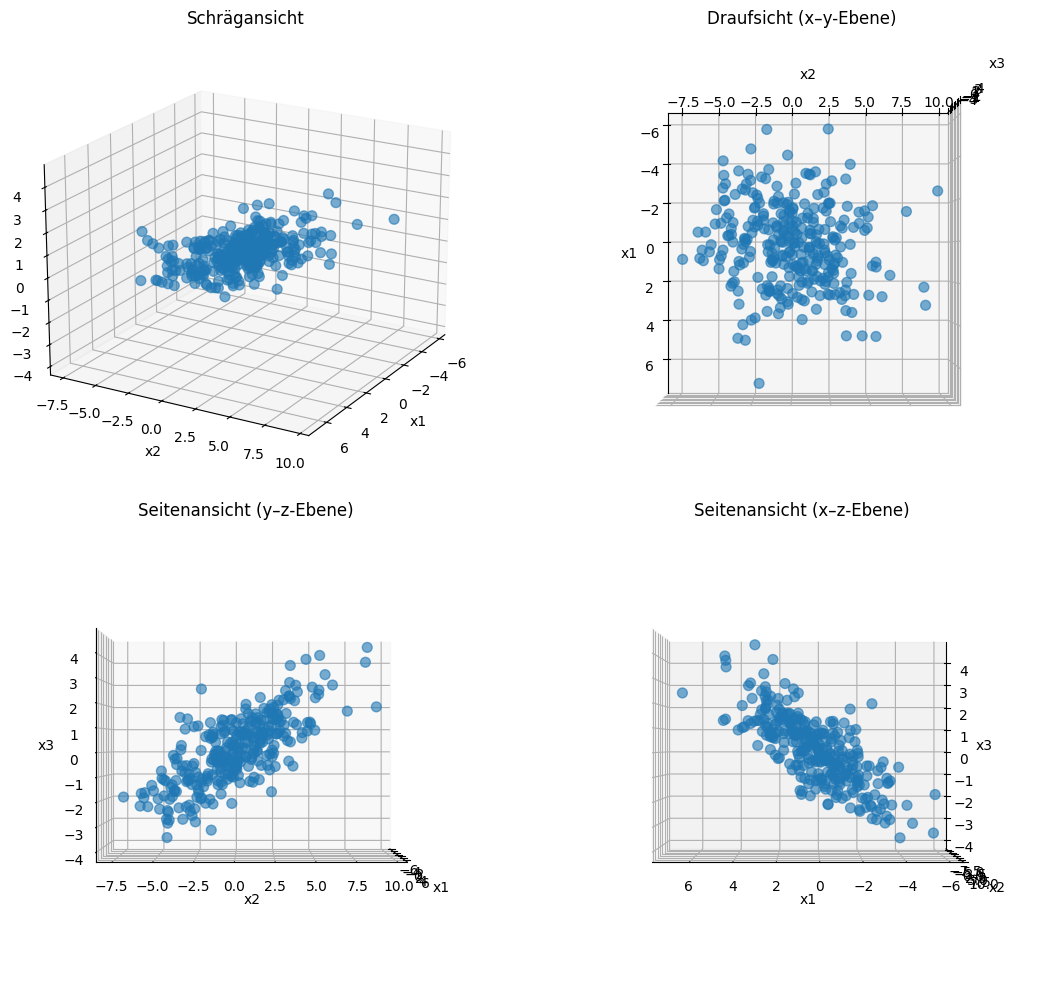

In [8]:
s = rng.normal(size=300);t = rng.normal(size=300)
X3 = np.column_stack([2*t + 0.07*rng.normal(size=300), 
                     3*s + 0.05*rng.normal(size=300), 
                     1*(t+s) + 0.1*rng.normal(size=300)])

# ... und visualisieren
from mpl_toolkits.mplot3d import Axes3D  # aktiviert 3D-Projektion
def plot_views(X):
    fig = plt.figure(figsize=(12, 10))
    views = [
        (20, 30,  "Schrägansicht"),
        (90, 0,   "Draufsicht (x–y-Ebene)"),
        (0, 0,    "Seitenansicht (y–z-Ebene)"),
        (0, 90,   "Seitenansicht (x–z-Ebene)")
    ]
    for i, (elev, azim, title) in enumerate(views, 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], s=50, alpha=0.6)
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(title); ax.set_xlabel("x1")
        ax.set_ylabel("x2"); ax.set_zlabel("x3")
    plt.tight_layout()
    plt.show()

plot_views(X3)

In [9]:
U, scores, Xrec, rmse = pca_k(X3, k=2)
print("U =", U,"RMSE=",rmse)

U = [[ 0.2670204   0.86617444  0.42242389]
 [ 0.86445441 -0.40902277  0.29226523]] RMSE= 0.09211512579524585


Vergleich mit sklearn

In [10]:
pca = PCA(n_components=2)
transformiert = pca.fit_transform(X3)
print(pca.components_)

[[ 0.26702236  0.86617471  0.42242211]
 [ 0.86445421 -0.4090248   0.29226295]]
